In [1]:
# Install and import libraries
!pip install pandas xlwings
import pandas as pd
import math
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize._numdiff import approx_derivative

In [3]:
# Data import
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
sheet_name = "Calibration"
data_degr = pd.read_excel(file_path, sheet_name=sheet_name, usecols="A,D:F,H", skiprows=1)
data_degr = data_degr[data_degr.iloc[:, 0].str.contains("D-PE-", na=False)]
print(data_degr)

# Known variables
k_degr_i_j = data_degr.iloc[:, 1].values
s = data_degr.iloc[:, 2].values
I_j = data_degr.iloc[:, 3].values
C_j = data_degr.iloc[:, 4].values
print(I_j)

'''
x_i, tau_i, y_i, theta_i, z_i, eta_i (float): Empirical constants for polymer i
s (float): Surface area to volume ratio [cm^-1]
I_j (float): UV intensity in compartment j [W/m^2]
C_j (float): Microbial concentration in compartment j [CFU/ml]
k_degr_i_j (float): The calculated degradation rate constant [d^-1] for polymer i in compartment j
'''

     D.P.I.  k [i,j] [d-1]      s [cm-1]  I_j [W/m2]  C_j [CFU/ml]
71  D-PE-01       0.000013  14851.485149       1.776  0.000000e+00
72  D-PE-02       0.005812   1010.000000       0.000  2.548800e+09
73  D-PE-03       0.001710   1010.000000       0.000  8.938500e+08
74  D-PE-04       0.002063   1010.000000       0.000  1.097400e+09
75  D-PE-05       0.000995    800.000000       0.000  1.239000e+09
76  D-PE-06       0.000792    800.000000       0.000  2.672700e+08
77  D-PE-07       0.000102     33.000000      14.000  7.200000e+01
[ 1.776  0.     0.     0.     0.     0.    14.   ]


'\nx_i, tau_i, y_i, theta_i, z_i, eta_i (float): Empirical constants for polymer i\ns (float): Surface area to volume ratio [cm^-1]\nI_j (float): UV intensity in compartment j [W/m^2]\nC_j (float): Microbial concentration in compartment j [CFU/ml]\nk_degr_i_j (float): The calculated degradation rate constant [d^-1] for polymer i in compartment j\n'

In [5]:
# Model definition (linear popt, log params_std)
def RC_degr(params, s, I_j, C_j):
    y_i, tau_i, xi_I_i, theta_i, xi_C_i, eta_i = params
    return y_i * (s**tau_i) * (I_j + xi_I_i)**theta_i * (C_j + xi_C_i)**eta_i

# Log-space curve fitting (more suitable for rate constants spanning orders of magnitude)
def log_model_degr(inputs, y_i, tau_i, xi_I_i, theta_i, xi_C_i, eta_i):
    s, I_j, C_j = inputs
    params = [y_i, tau_i, xi_I_i, theta_i, xi_C_i, eta_i]
    k_degr = RC_degr(params, s, I_j, C_j)
    return np.log(k_degr)
    
# Prepare inputs (X) and outputs (Y) arrays
X = (s, I_j, C_j)
Y = np.log(k_degr_i_j)

# Fitting settings (Initial guesses, bounds, convergence threshold, maximum iterations)
initial_guess = [1, 1, 1, 1, 1, 1]
bounds = ([0]*6, [np.inf]*6) # Lower and upper bounds
tolerance = 0.001  # 0.1%
max_iterations = 1000

lower_bounds = [0, 0, 0, 0, 0, 0]  # Lower bounds: Set manually
upper_bounds = [np.inf] * len(initial_guess)  # Upper bounds: Infinity

# The loop for iterations
for iteration in range(max_iterations):
    # Perform curve fitting (maxfev: maximum function evaluations, which is calculated as: maxfev=200×(number of parameters + 1)
    # Fit log-transformed model to log-transformed data
    popt, pcov = curve_fit(log_model_degr, X, Y, p0=initial_guess, bounds=bounds, maxfev=2000)
    # Calculate the relative difference
    relative_diff = np.abs(popt - initial_guess) / np.abs(initial_guess)
    # Update the initial guess
    initial_guess = popt
    # Check for convergence
    if np.all(relative_diff < tolerance):
        print(f"Converged after {iteration + 1} iterations.")
        break
else:
    print("Reached the maximum number of iterations without full convergence.")

# Fitted parameters (i.e., parameter estimates), in linear space
parameter_names = ['y_i', 'tau_i', 'xi_I_i', 'theta_i', 'xi_C_i', 'eta_i']
for name, value in zip(parameter_names, popt):
    print(f"{name}: {value}")

Converged after 34 iterations.
y_i: 2.7493088561665876e-09
tau_i: 0.7489326912090547
xi_I_i: 0.5471566334151596
theta_i: 2.2015638261833064
xi_C_i: 0.26434310299586283
eta_i: 0.46358726428113683


In [7]:
# Compute determination coefficient (R^2) while fully staying in log-space
# Step 1: Compute log-observed and log-predicted
eps = 1e-10  # Small constant to avoid log(0) issues
log_obs = np.log(k_degr_i_j + eps)  # Avoid log(0)
log_pred = log_model_degr(X, *popt)  # Already log(k_pred)


# Step 2: Compute SS_res and SS_tot in log-space
ss_res_log = np.sum((log_obs - log_pred)**2)
ss_tot_log = np.sum((log_obs - np.mean(log_obs))**2)

# Step 3: Compute R² in log-space
r_squared_log = 1 - (ss_res_log / ss_tot_log)
print(f"Log-space R² (pseudo-R²): {r_squared_log:.3f}")

Log-space R² (pseudo-R²): 0.969


In [9]:
# Save fitted parameters back to Excel (without modifying)
import xlwings as xw

# File path and sheet details
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
sheet_name = "Drop-down lists"
start_row = 19  # Change for other polymer types (17-26)
start_col = "C"

# Fitted parameters
fitted_parameters = popt

# Start the Excel application and open the workbook
app = xw.App(visible=True)  # Set visible=True to open the file automatically
workbook = app.books.open(file_path)
sheet = workbook.sheets[sheet_name]

# Write the fitted parameters to the specified cells
for i, value in enumerate(fitted_parameters):
    column = chr(ord(start_col) + i)
    cell = f"{column}{start_row}"
    sheet.range(cell).value = value

# Save the workbook
workbook.save()
workbook.close()
app.quit()

   D.P.I..1 R.E.S..1 k_model [d-1].1 k [i,j] [d-1].1
24  D-PE-01       UV        1.26e-05        1.26e-05
25  D-PE-02       MC        2.97e-03        5.81e-03
26  D-PE-03       MC        1.83e-03        1.71e-03
27  D-PE-04       MC        2.01e-03        2.06e-03
28  D-PE-05       MC        1.79e-03        9.95e-04
29  D-PE-06       MC        8.78e-04        7.92e-04
30  D-PE-07    UV+MC        9.96e-05        1.02e-04


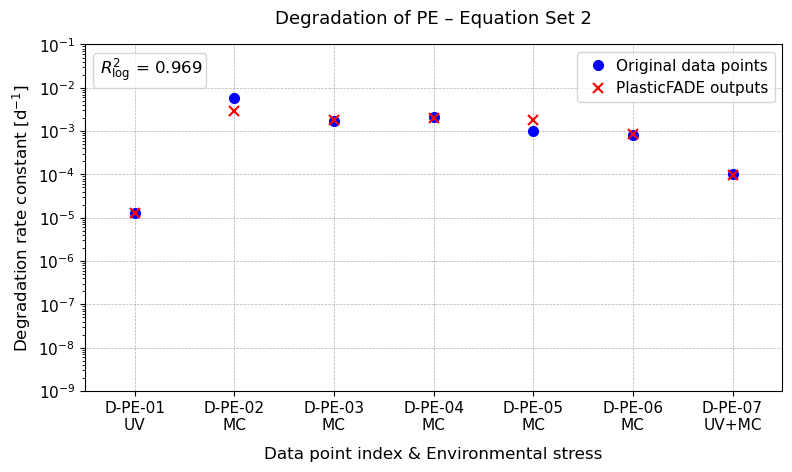

In [9]:
# Plot the modeling results with the original data points in the same graph
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Import the original data points and calculated RCs from PlasticFADE
import matplotlib.pyplot as plt
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
data_comp = pd.read_excel(file_path, sheet_name="Scatterplot", usecols="I:L", skiprows=5)  # Change usecols and skiprows for other polymers
data_comp = data_comp[data_comp.iloc[:, 0].str.contains("D-PE-", na=False)] # Change for other polymer types
pd.set_option('display.float_format', '{:.2e}'.format)
print(data_comp)

fig, ax = plt.subplots(figsize=(9, 4.5))
df = pd.DataFrame(data_comp)
df['x_labels'] = df['D.P.I..1'] + '\n' + df['R.E.S..1']

# Plot original data and model output
ax.plot(df['D.P.I..1'], df['k [i,j] [d-1].1'], 'bo', markersize=7, label='Original data points')
ax.plot(df['D.P.I..1'], df['k_model [d-1].1'], 'rx', markersize=7, markeredgewidth=1.5, label='PlasticFADE outputs')

# Main legend
main_legend = ax.legend(loc='upper right', handletextpad=0.2, fontsize=11)
ax.add_artist(main_legend)  # keep it when adding another legend

# --- Create second legend entry for R² without marker ---
r2_label = f'$R_{{\\mathrm{{log}}}}^2$ = {r_squared_log:.3f}'

# Make an invisible Line2D object (no line, no marker)
empty_line = Line2D([], [], color='none')

# Add the second legend with zero padding before the text
r2_legend = ax.legend([empty_line], [r2_label], loc='upper left', frameon=True, handlelength=0, handletextpad=0.2, borderpad=0.2, fontsize=12)

plt.xticks(df['D.P.I..1'], df['x_labels'])
plt.xlim(-0.5, len(data_comp) - 0.5)
ax.set_xlabel('Data point index & Environmental stress', labelpad=10, fontsize=12)
ax.set_ylabel('Degradation rate constant [d$^{-1}$]', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.grid(True, which="major", ls="--", lw=0.5)
ax.set_title('Degradation of PE – Equation Set 2', pad=15, fontsize=13)

plt.savefig("/Users/elchulito/D_PE_S2.png", dpi=600, bbox_inches='tight')
plt.show()